In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sudan-pol-viol-events/sudan_political_violence_events.xlsx
/kaggle/input/sudan-social-and-economic-indicators-2000-2024/SudanWorld Development indicators .csv


# Sudan: Conflict & Socio-Economic Indicators (2000–2024)
**Goal:** analyze the relationship between political violence (events & fatalities) and macroeconomic indicators for Sudan; produce cleaned dataset, exploratory analysis, engineered features, and baseline predictive models for conflict fatalities.

**Deliverables**
- Cleaned merged dataset saved to `/kaggle/working/sudan_merged_conflict_economy.csv`
- EDA: time-series plots, correlations, regional summary (when available)
- Feature engineering: per-100k rates, rolling averages, GDP per capita
- Modeling: baseline (mean), Random Forest with time-series CV, metrics and feature importances
- Reproducibility: seeds, deterministic splits, and instructions

**Assumptions**
- Political violence file is: `/kaggle/input/sudan-pol-viol-events/sudan_political_violence_events.xlsx`
- Socio-economic file is: `/kaggle/input/sudan-social-and-economic-indicators-2000-2024/SudanWorld Development indicators .csv`

# 1.Imports & global settings 

Install and import libraries, set plotting defaults and a random seed for reproducibility.


In [2]:
#  Imports & settings
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 2.Files, detection and explicit paths
Explicitly assign the two files to avoid mistaken duplicate loads. These paths reflect the files present in your Kaggle input root.


In [3]:
# File paths 
INPUT_ROOT = '/kaggle/input'
violence_path = '/kaggle/input/sudan-pol-viol-events/sudan_political_violence_events.xlsx'
socio_eco_path = '/kaggle/input/sudan-social-and-economic-indicators-2000-2024/SudanWorld Development indicators .csv'

assert os.path.exists(violence_path), f"Violence file not found at {violence_path}"
assert os.path.exists(socio_eco_path), f"Socio-economic file not found at {socio_eco_path}"
print("Files detected:")
print(" - Violence:", violence_path)
print(" - Socio-economic:", socio_eco_path)

Files detected:
 - Violence: /kaggle/input/sudan-pol-viol-events/sudan_political_violence_events.xlsx
 - Socio-economic: /kaggle/input/sudan-social-and-economic-indicators-2000-2024/SudanWorld Development indicators .csv


# 3.Load raw data 
Load both datasets. Preview dimensions and first rows.


In [4]:
# Load raw files
df_violence_raw = pd.read_excel(violence_path)
df_econ_raw = pd.read_csv(socio_eco_path)

print("Violence shape:", df_violence_raw.shape)
print("Economy shape:", df_econ_raw.shape)
display(df_violence_raw.head(3))
display(df_econ_raw.head(3))

Violence shape: (68012, 10)
Economy shape: (17, 47)


,Country,Admin1,Admin2,ISO3,Admin2 Pcode,Admin1 Pcode,Month,Year,Events,Fatalities
0,Sudan,Al Jazirah,Al Hasahisa,SDN,SD15034,SD15,January,1997,0,0
1,Sudan,Blue Nile,Ed Damazine,SDN,SD08105,SD08,January,1997,8,612
2,Sudan,Blue Nile,Wad Al Mahi,SDN,SD08110,SD08,January,1997,3,0


,Country Name,Country Code,Time,Time Code,"Population, total [SP.POP.TOTL]",Population growth (annual %) [SP.POP.GROW],Surface area (sq. km) [AG.SRF.TOTL.K2],Population density (people per sq. km of land area) [EN.POP.DNST],"GNI, Atlas method (current US$) [NY.GNP.ATLS.CD]","GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]",...,Mobile cellular subscriptions (per 100 people) [IT.CEL.SETS.P2],High-technology exports (% of manufactured exports) [TX.VAL.TECH.MF.ZS],Merchandise trade (% of GDP) [TG.VAL.TOTL.GD.ZS],Net barter terms of trade index (2015 = 100) [TT.PRI.MRCH.XD.WD],"External debt stocks, total (DOD, current US$) [DT.DOD.DECT.CD]","Total debt service (% of exports of goods, services and primary income) [DT.TDS.DECT.EX.ZS]",Net migration [SM.POP.NETM],"Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]","Foreign direct investment, net inflows (BoP, current US$) [BX.KLT.DINV.CD.WD]",Net official development assistance and official aid received (current US$) [DT.ODA.ALLD.CD]
0,Sudan,SDN,1990.0,YR1990,22021481.0,2.034309,2505810,..,2.013605e+10,750.0,...,0,..,2.951736,..,14798052810,9.710886156,-254825.0,6.190000e+07,-31130000,848239990.2
1,Sudan,SDN,2000.0,YR2000,27816745.0,2.497546,2505810,..,1.132862e+10,330.0,...,0.082684,..,27.412238,..,16097061560,13.47285264,-165030.0,6.408000e+08,392200000,225291000.4
2,Sudan,SDN,2015.0,YR2015,40024431.0,3.046900,1878000,21.42635493,4.742149e+10,1180.0,...,69.8036,0.6918046702,24.509558,100,21657734194,10.65049262,66476.0,1.513920e+08,1728373403,969695556.6


# 4.Problem statement & expected outputs 

Define the analytical question and expected outputs 

**Primary question:** How do political violence metrics (events, fatalities) relate to Sudan's socio-economic indicators over time?  
**Secondary objectives:** identify leading indicators, build a baseline model to (a) explain variance in fatalities using economic features and (b) evaluate predictability with time-aware CV.  
**Expected outputs:** cleaned dataset, EDA visualizations, feature importance and model performance metrics.

# 5. Data quality and year normalization helpers

Functions to standardize year columns and locate World Bank-style indicator headers robustly.

In [5]:
#  Helper functions
def ensure_year_column(df, candidates=['Year','year','YEAR','Time','time','Time Code']):
    for c in candidates:
        if c in df.columns:
            df = df.rename(columns={c: 'Year'})
            break
    if 'Year' not in df.columns:
        # try to extract from 'Time Code' style like 'YR2015'
        for col in df.columns:
            if df[col].astype(str).str.contains(r'\bYR\d{4}\b', na=False).any():
                df['Year'] = df[col].astype(str).str.extract(r'(\d{4})').astype(float).astype('Int64')
                break
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    df = df.dropna(subset=['Year']).copy()
    df['Year'] = df['Year'].astype(int)
    return df

def find_col(df, keywords):
    keys = [k.lower() for k in (keywords if isinstance(keywords, (list,tuple)) else [keywords])]
    for c in df.columns:
        cl = c.lower()
        if any(k in cl for k in keys):
            return c
    return None

# 6. Clean & normalize violence dataset

Standardize year, coerce event/fatality numeric columns, and aggregate to annual totals. Also preserve regional fields if present.


In [6]:
#  Clean violence data
df_violence = ensure_year_column(df_violence_raw)

# Try common column names for events/fatalities
events_col = find_col(df_violence, ['event','events','incidents'])
fatal_col = find_col(df_violence, ['fatal','deaths','killed'])

if events_col is None:
    df_violence['Events'] = 0
else:
    df_violence['Events'] = pd.to_numeric(df_violence[events_col].replace(['..',''], np.nan), errors='coerce').fillna(0).astype(int)

if fatal_col is None:
    df_violence['Fatalities'] = 0
else:
    df_violence['Fatalities'] = pd.to_numeric(df_violence[fatal_col].replace(['..',''], np.nan), errors='coerce').fillna(0).astype(int)

# Keep Admin1 if present (for regional aggregations)
admin1_col = find_col(df_violence, ['admin1','state','region','province'])

violence_yearly = df_violence.groupby('Year', as_index=False)[['Events','Fatalities']].sum()
print("Aggregated violence (yearly) shape:", violence_yearly.shape)
display(violence_yearly.tail())

Aggregated violence (yearly) shape: (29, 3)


,Year,Events,Fatalities
24,2021,683,1634
25,2022,909,2129
26,2023,4883,17011
27,2024,5949,16640
28,2025,3374,16416


# 7.Clean & select socio-economic data
Standardize year and map key economic indicators to shorter names for analysis.


In [7]:
#  Clean socio-economic data
df_econ = ensure_year_column(df_econ_raw)

mapping = {
    'Population': ['population, total','population total','sp.pop.totl'],
    'GDP_USD': ['gdp (current','gdp (current us','ny.gdp.mktp.cd'],
    'Inflation': ['inflation', 'gdp deflator', 'ny.gdp.defl.kd.zg'],
    'Mobile_subs_per100': ['mobile cellular subscriptions', 'mobile cellular', 'it.cel.sets.p2'],
    'School_primary': ['primary completion', 'se.prm.cmpt.zs', 'primary completion rate']
}

detected = {}
for short, keys in mapping.items():
    detected[short] = find_col(df_econ, keys)

print("Detected columns:")
for k,v in detected.items():
    print(f" - {k:20} -> {v}")

keep_cols = ['Year'] + [v for v in detected.values() if v is not None]
df_econ_clean = df_econ[keep_cols].copy()
rename_map = {v:k for k,v in detected.items() if v is not None}
df_econ_clean.rename(columns=rename_map, inplace=True)

# Coerce to numeric and handle '..' placeholders
for c in [c for c in ['Population','GDP_USD','Inflation','Mobile_subs_per100','School_primary'] if c in df_econ_clean.columns]:
    df_econ_clean[c] = pd.to_numeric(df_econ_clean[c].replace(['..',''], np.nan), errors='coerce')

display(df_econ_clean.head())
df_econ_clean.info()

Detected columns:
 - Population           -> Population, total [SP.POP.TOTL]
 - GDP_USD              -> GDP (current US$) [NY.GDP.MKTP.CD]
 - Inflation            -> Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]
 - Mobile_subs_per100   -> Mobile cellular subscriptions (per 100 people) [IT.CEL.SETS.P2]
 - School_primary       -> Primary completion rate, total (% of relevant age group) [SE.PRM.CMPT.ZS]


,Year,Population,GDP_USD,Inflation,Mobile_subs_per100,School_primary
0,1990,22021481.0,3.364122e+10,66.235588,0.000000,NaN
1,2000,27816745.0,1.225730e+10,9.853137,0.082684,NaN
2,2015,40024431.0,5.172676e+10,14.022557,69.803600,55.016880
3,2016,41259892.0,4.263038e+10,20.685588,67.395500,55.382622
4,2017,42714306.0,4.128362e+10,34.622371,67.059800,56.869820


<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                12 non-null     int64  
 1   Population          12 non-null     float64
 2   GDP_USD             12 non-null     float64
 3   Inflation           12 non-null     float64
 4   Mobile_subs_per100  10 non-null     float64
 5   School_primary      5 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 672.0 bytes


# 8.Merge datasets & create derived metrics 

Merge on Year (inner join). Create GDP per capita, events/fatalities per 100k, rolling averages, and export a cleaned CSV.

In [8]:
# Merge and derive
df_merged = pd.merge(df_econ_clean, violence_yearly, on='Year', how='inner')
df_merged = df_merged.sort_values('Year').reset_index(drop=True)

if 'Population' in df_merged.columns and 'GDP_USD' in df_merged.columns:
    df_merged['GDP_per_capita'] = df_merged.apply(lambda r: r['GDP_USD']/r['Population'] if pd.notna(r['GDP_USD']) and pd.notna(r['Population']) and r['Population']>0 else np.nan, axis=1)

if 'Population' in df_merged.columns:
    df_merged['Events_per_100k'] = df_merged.apply(lambda r: r['Events']/(r['Population']/100000) if pd.notna(r['Population']) and r['Population']>0 else np.nan, axis=1)
    df_merged['Fatalities_per_100k'] = df_merged.apply(lambda r: r['Fatalities']/(r['Population']/100000) if pd.notna(r['Population']) and r['Population']>0 else np.nan, axis=1)

# Rolling 3-year averages
for col in ['Events','Fatalities','Events_per_100k','Fatalities_per_100k','GDP_USD','Inflation']:
    if col in df_merged.columns:
        df_merged[f'{col}_3yr_avg'] = df_merged[col].rolling(window=3, min_periods=1).mean()

out_path = '/kaggle/working/sudan_merged_conflict_economy.csv'
df_merged.to_csv(out_path, index=False)
print("Merged dataset saved to:", out_path)
display(df_merged.head())

Merged dataset saved to: /kaggle/working/sudan_merged_conflict_economy.csv


,Year,Population,GDP_USD,Inflation,Mobile_subs_per100,School_primary,Events,Fatalities,GDP_per_capita,Events_per_100k,Fatalities_per_100k,Events_3yr_avg,Fatalities_3yr_avg,Events_per_100k_3yr_avg,Fatalities_per_100k_3yr_avg,GDP_USD_3yr_avg,Inflation_3yr_avg
0,2000,27816745.0,1.225730e+10,9.853137,0.082684,NaN,177,1393,440.644624,0.636307,5.007775,177.000000,1393.000000,0.636307,5.007775,1.225730e+10,9.853137
1,2015,40024431.0,5.172676e+10,14.022557,69.803600,55.016880,1188,3495,1292.379614,2.968187,8.732167,682.500000,2444.000000,1.802247,6.869971,3.199203e+10,11.937847
2,2016,41259892.0,4.263038e+10,20.685588,67.395500,55.382622,1190,3889,1033.215889,2.884157,9.425618,851.666667,2925.666667,2.162884,7.721853,3.553814e+10,14.853761
3,2017,42714306.0,4.128362e+10,34.622371,67.059800,56.869820,594,1291,966.505647,1.390635,3.022407,990.666667,2891.666667,2.414326,7.060064,4.521358e+10,23.110172
4,2018,44230596.0,3.233378e+10,55.975325,68.053400,58.914009,502,1033,731.027463,1.134961,2.335487,762.000000,2071.000000,1.803251,4.927837,3.874926e+10,37.094428


# 9.High-quality EDA: Time-series overview 

Plot year-by-year time series for Events and Fatalities and overlay key economic indicators (GDP, Inflation).
Interpretation should be added under each figure in Markdown cells after the plots.


In [9]:
# Time series: Events & Fatalities
if {'Year','Events','Fatalities'}.issubset(df_merged.columns):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Bar(x=df_merged['Year'], y=df_merged['Events'], name='Events', opacity=0.6), secondary_y=False)
    fig.add_trace(go.Line(x=df_merged['Year'], y=df_merged['Fatalities'], name='Fatalities', line=dict(width=3)), secondary_y=True)
    fig.update_layout(title_text="Yearly Conflict Events (bar) and Fatalities (line)")
    fig.update_xaxes(title_text="Year")
    fig.update_yaxes(title_text="Events (count)", secondary_y=False)
    fig.update_yaxes(title_text="Fatalities (count)", secondary_y=True)
    fig.show()
else:
    print("Not enough columns to plot Events/Fatalities time-series.")

/usr/local/lib/python3.11/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# 10. EDA: Economic trends overlay 
Overlay GDP_USD and Fatalities to visually inspect co-movements; also show Inflation vs Events scatter with sizing by Fatalities.


In [10]:
# GDP vs Fatalities overlay and Inflation vs Events scatter
if 'GDP_USD' in df_merged.columns and 'Fatalities' in df_merged.columns:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Line(x=df_merged['Year'], y=df_merged['GDP_USD'], name='GDP (USD)'), secondary_y=False)
    fig.add_trace(go.Bar(x=df_merged['Year'], y=df_merged['Fatalities'], name='Fatalities', opacity=0.4), secondary_y=True)
    fig.update_layout(title_text="GDP (USD) vs Fatalities")
    fig.show()

if 'Inflation' in df_merged.columns and 'Events' in df_merged.columns:
    fig = px.scatter(df_merged, x='Events', y='Inflation', size='Fatalities' if 'Fatalities' in df_merged.columns else None, hover_name='Year', title="Events vs Inflation (size=Fatalities)")
    fig.update_layout(xaxis_title='Events', yaxis_title='Inflation (%)')
    fig.show()

# 11.EDA: Correlation matrix

Compute correlation matrix on numeric features and show heatmap for interpretability.

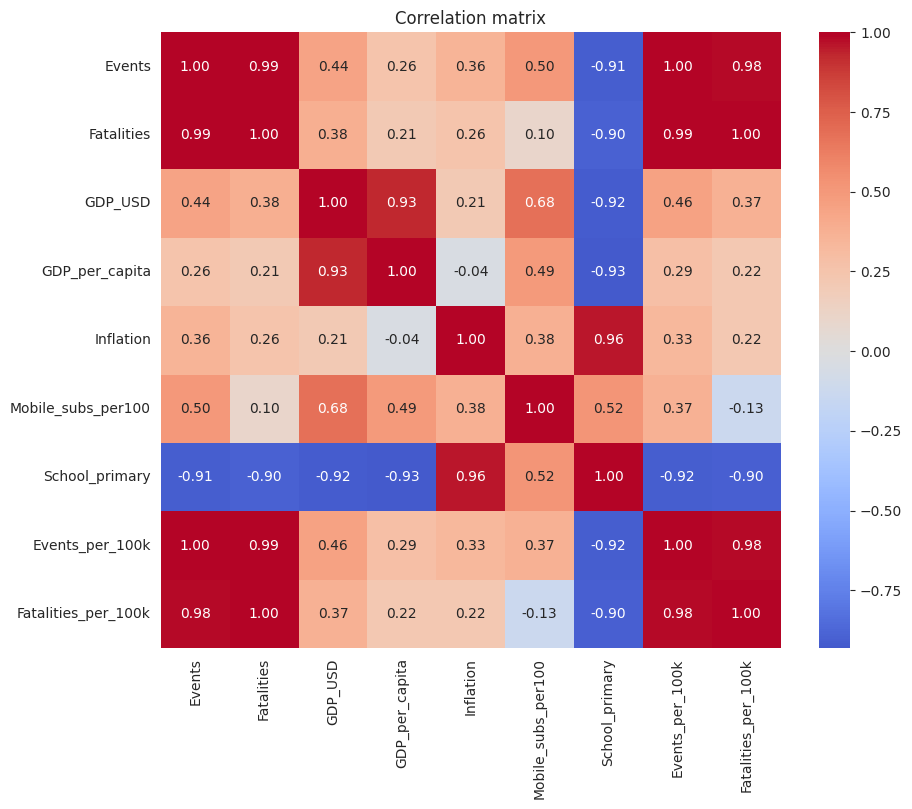

In [11]:
# Correlation heatmap
corr_cols = [c for c in ['Events','Fatalities','GDP_USD','GDP_per_capita','Inflation','Mobile_subs_per100','School_primary','Events_per_100k','Fatalities_per_100k'] if c in df_merged.columns]
if len(corr_cols) >= 2:
    corr_matrix = df_merged[corr_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title("Correlation matrix")
    plt.show()
else:
    print("Not enough numeric columns to compute correlation matrix. Found:", corr_cols)

# 12. Regional breakdown (if available)

If the violence dataset included an Admin1/state column, aggregate and show the top affected regions.


,Admin1,Events,Fatalities
10,North Darfur,4650,33161
9,Khartoum,6814,12463
6,Equatoria,767,10996
16,South Darfur,2487,10915
18,West Darfur,1234,10891
17,South Kordofan,1670,8751
3,Blue Nile,521,7058
4,Central Darfur,1735,6810
1,Al Jazirah,1660,5127
2,Bahr el Ghazal,337,5058


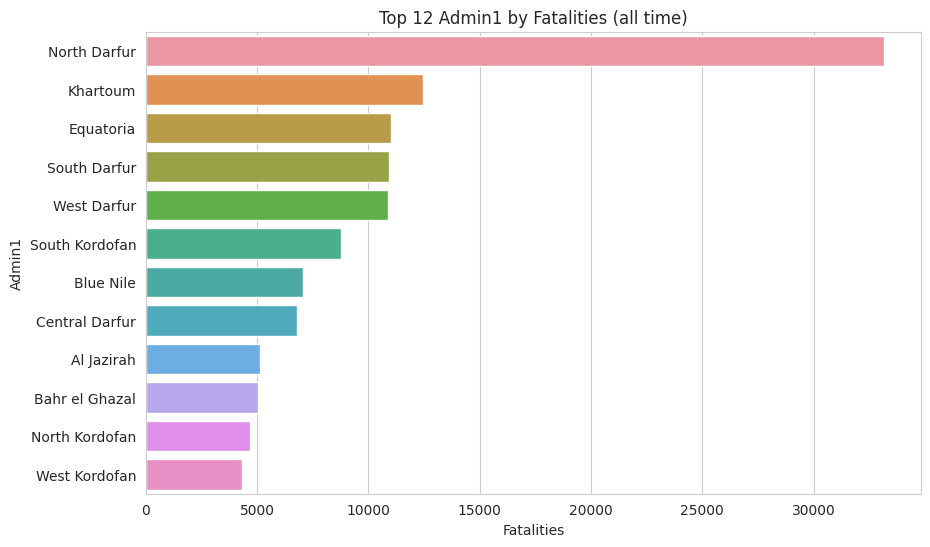

In [12]:
#  Regional aggregation (if Admin1 exists)
if admin1_col is not None and admin1_col in df_violence.columns:
    df_reg = df_violence.groupby(admin1_col, as_index=False)[['Events','Fatalities']].sum().sort_values('Fatalities', ascending=False)
    display(df_reg.head(12))
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_reg.head(12), x='Fatalities', y=admin1_col)
    plt.title('Top 12 Admin1 by Fatalities (all time)')
    plt.show()
else:
    print("No Admin1/state column available in violence dataset. Regional breakdown skipped.")

# 13. Data quality checks & missing value strategy

Report missingness and specify how missing values will be handled for modeling: median imputation for numeric features.


In [13]:
#  Missing value report
missing_report = df_merged.isna().sum().to_frame(name='missing_count')
missing_report['missing_pct'] = missing_report['missing_count'] / df_merged.shape[0] * 100
display(missing_report.sort_values('missing_pct', ascending=False).head(20))

,missing_count,missing_pct
School_primary,6,54.545455
Mobile_subs_per100,2,18.181818
Year,0,0.000000
Fatalities_per_100k,0,0.000000
GDP_USD_3yr_avg,0,0.000000
Fatalities_per_100k_3yr_avg,0,0.000000
Events_per_100k_3yr_avg,0,0.000000
Fatalities_3yr_avg,0,0.000000
Events_3yr_avg,0,0.000000
GDP_per_capita,0,0.000000


# 14. Feature selection & engineering for modeling 

Define target and candidate features. Exclude target leakage and create lag features and rolling averages where appropriate.


In [14]:
# Feature engineering for modeling
model_df = df_merged.copy()

# Target
TARGET = 'Fatalities'

# Candidate numeric features (exclude Year and direct targets)
candidate_features = [c for c in model_df.columns if model_df[c].dtype in [np.float64, np.int64] and c not in ['Year','Events','Fatalities']]

# Exclude columns with too many missing values (>50%)
valid_cols = [c for c in candidate_features if model_df[c].isna().mean() <= 0.5]

# Create time-lag features for important predictors (1-year lag of GDP_per_capita, Inflation)
for col in ['GDP_per_capita','GDP_USD','Inflation','Events','Events_per_100k']:
    if col in model_df.columns:
        model_df[f'{col}_lag1'] = model_df[col].shift(1)

# Drop rows with missing target or that lost lagged rows
model_df = model_df.dropna(subset=[TARGET]).reset_index(drop=True)

# Final features set (drop columns still with >50% missing)
features = [c for c in model_df.columns if c not in ['Year','Fatalities','Events'] and model_df[c].dtype in [np.float64, np.int64]]
features = [c for c in features if model_df[c].isna().mean() <= 0.5]

print("Final modeling features:", features)
display(model_df[['Year','Fatalities'] + features].head())

Final modeling features: ['Population', 'GDP_USD', 'Inflation', 'Mobile_subs_per100', 'GDP_per_capita', 'Events_per_100k', 'Fatalities_per_100k', 'Events_3yr_avg', 'Fatalities_3yr_avg', 'Events_per_100k_3yr_avg', 'Fatalities_per_100k_3yr_avg', 'GDP_USD_3yr_avg', 'Inflation_3yr_avg', 'GDP_per_capita_lag1', 'GDP_USD_lag1', 'Inflation_lag1', 'Events_lag1', 'Events_per_100k_lag1']


,Year,Fatalities,Population,GDP_USD,Inflation,Mobile_subs_per100,GDP_per_capita,Events_per_100k,Fatalities_per_100k,Events_3yr_avg,Fatalities_3yr_avg,Events_per_100k_3yr_avg,Fatalities_per_100k_3yr_avg,GDP_USD_3yr_avg,Inflation_3yr_avg,GDP_per_capita_lag1,GDP_USD_lag1,Inflation_lag1,Events_lag1,Events_per_100k_lag1
0,2000,1393,27816745.0,1.225730e+10,9.853137,0.082684,440.644624,0.636307,5.007775,177.000000,1393.000000,0.636307,5.007775,1.225730e+10,9.853137,NaN,NaN,NaN,NaN,NaN
1,2015,3495,40024431.0,5.172676e+10,14.022557,69.803600,1292.379614,2.968187,8.732167,682.500000,2444.000000,1.802247,6.869971,3.199203e+10,11.937847,440.644624,1.225730e+10,9.853137,177.0,0.636307
2,2016,3889,41259892.0,4.263038e+10,20.685588,67.395500,1033.215889,2.884157,9.425618,851.666667,2925.666667,2.162884,7.721853,3.553814e+10,14.853761,1292.379614,5.172676e+10,14.022557,1188.0,2.968187
3,2017,1291,42714306.0,4.128362e+10,34.622371,67.059800,966.505647,1.390635,3.022407,990.666667,2891.666667,2.414326,7.060064,4.521358e+10,23.110172,1033.215889,4.263038e+10,20.685588,1190.0,2.884157
4,2018,1033,44230596.0,3.233378e+10,55.975325,68.053400,731.027463,1.134961,2.335487,762.000000,2071.000000,1.803251,4.927837,3.874926e+10,37.094428,966.505647,4.128362e+10,34.622371,594.0,1.390635


# 15. Train/test split (time-aware)

Keep the time-series nature: use the last `n_test_years` as a hold-out test set and perform time-series cross-validation on the training set.


In [15]:
# Time-aware train/test split
n_test_years = 2  # changeable parameter
years_sorted = sorted(model_df['Year'].unique())
if len(years_sorted) < (n_test_years + 1):
    raise ValueError("Not enough years to create a test set with the requested n_test_years.")

test_years = years_sorted[-n_test_years:]
train_df = model_df[~model_df['Year'].isin(test_years)].reset_index(drop=True)
test_df = model_df[model_df['Year'].isin(test_years)].reset_index(drop=True)

X_train = train_df[features]
y_train = train_df[TARGET]
X_test = test_df[features]
y_test = test_df[TARGET]

print("Train years:", sorted(train_df['Year'].unique()))
print("Test years:", sorted(test_df['Year'].unique()))
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train years: [2000, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Test years: [2023, 2024]
Train shape: (9, 18) Test shape: (2, 18)


# 16. Baseline model (mean predictor)

Evaluate a simple baseline (predict mean fatalities) to provide context for model improvements.


In [16]:
# Baseline
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
base_mae = mean_absolute_error(y_test, y_pred_base)
base_rmse = mean_squared_error(y_test, y_pred_base, squared=False)
base_r2 = r2_score(y_test, y_pred_base)
print(f"Baseline (mean) — MAE: {base_mae:.3f}, RMSE: {base_rmse:.3f}, R2: {base_r2:.3f}")

Baseline (mean) — MAE: 14986.167, RMSE: 14987.315, R2: -6526.695


# 17.Random Forest model with time-series CV

Pipeline: median imputer + RandomForestRegressor. Use TimeSeriesSplit for cross-validation and a small grid search for tuning.


In [17]:
#  RandomForest with TimeSeriesSplit & GridSearchCV
tscv = TimeSeriesSplit(n_splits=3)
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_SEED))
])

param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [None, 6, 12],
    'model__min_samples_leaf': [1, 3]
}

gsearch = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
gsearch.fit(X_train, y_train)

best_model = gsearch.best_estimator_
print("Best params:", gsearch.best_params_)
cv_score = -gsearch.best_score_
print(f"CV (neg MAE) -> MAE: {cv_score:.3f}")

Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
CV (neg MAE) -> MAE: 1076.848


# 18. Evaluate on hold-out test set 
Compute MAE, RMSE, R2 on the time-held-out test set and show predictions vs actual.

In [18]:
# Test evaluation
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {r2:.3f}")

# Predictions vs Actual plot
df_pred = pd.DataFrame({'Year': test_df['Year'], 'Actual': y_test, 'Predicted': y_pred})
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pred['Year'], y=df_pred['Actual'], name='Actual'))
fig.add_trace(go.Line(x=df_pred['Year'], y=df_pred['Predicted'], name='Predicted', line=dict(width=3)))
fig.update_layout(title="Actual vs Predicted Fatalities (Test Set)")
fig.show()

Test MAE: 14181.460
Test RMSE: 14184.331
Test R2: -5845.956


/usr/local/lib/python3.11/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# 19. Feature importance & interpretation 

Extract feature importances from the Random Forest and present them sorted. Provide a short interpretation of the top features.


Fatalities_per_100k            0.114061
Fatalities_per_100k_3yr_avg    0.102490
Events_per_100k                0.100738
Inflation_lag1                 0.091344
GDP_USD                        0.089856
Inflation                      0.077685
Population                     0.068459
GDP_per_capita_lag1            0.053035
GDP_per_capita                 0.049074
GDP_USD_lag1                   0.048097
Events_per_100k_lag1           0.044191
Inflation_3yr_avg              0.039897
Events_lag1                    0.034542
Fatalities_3yr_avg             0.032178
Events_per_100k_3yr_avg        0.031395
Events_3yr_avg                 0.012507
Mobile_subs_per100             0.007537
GDP_USD_3yr_avg                0.002912
dtype: float64

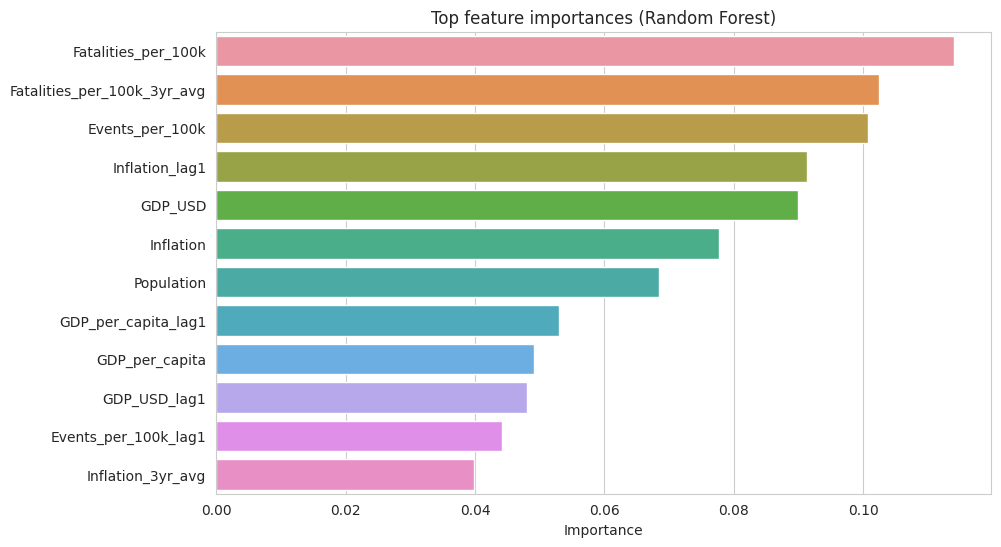

In [19]:
#  Feature importances
# Extract feature importances (RandomForest lives under pipeline.named_steps['model'])
rf = best_model.named_steps['model']
# Need to handle imputer/scaler changes in pipeline: features align with input feature order
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
display(importances.head(20))

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(12).values, y=importances.head(12).index)
plt.title("Top feature importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

# 20.Residual diagnostics 
Plot residuals to inspect bias and heteroskedasticity.

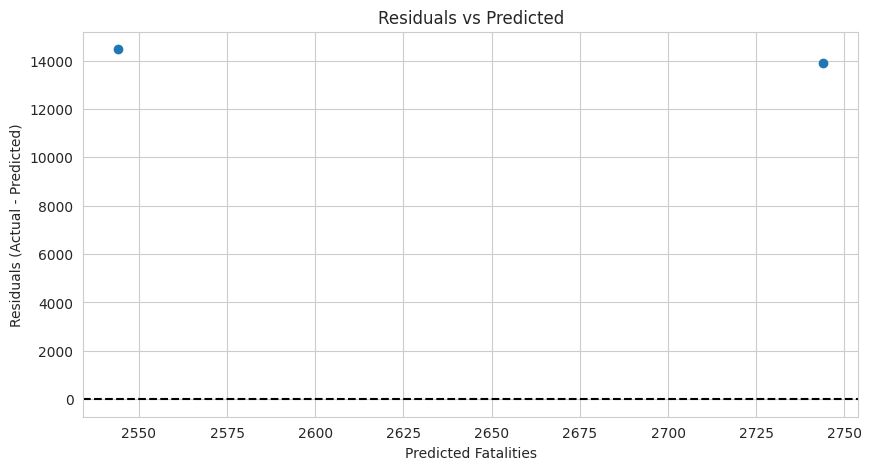

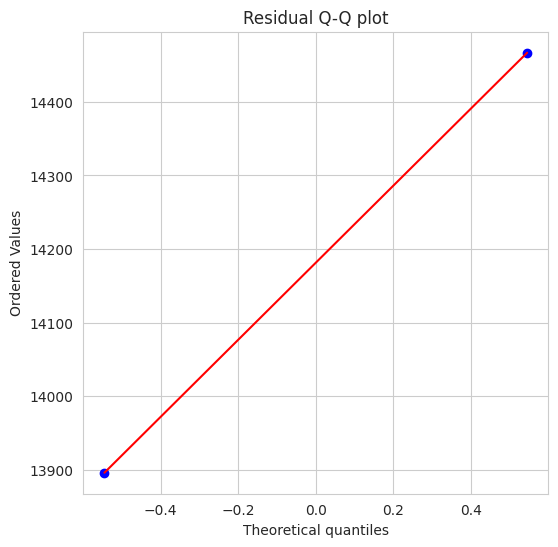

In [20]:
# Residuals
residuals = y_test.values - y_pred
plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Fatalities')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.show()

# Q-Q plot (rough) to check distribution
import scipy.stats as stats
plt.figure(figsize=(6,6))
stats.probplot(residuals, plot=plt)
plt.title('Residual Q-Q plot')
plt.show()

# 21. Save modeling artifacts & cleaned data (Markdown)

Save the cleaned merged dataset and the train/test splits to `/kaggle/working`, ready for download.


In [21]:
# Cell 21 - Save outputs
train_out = '/kaggle/working/sudan_train.csv'
test_out = '/kaggle/working/sudan_test.csv'
df_merged.to_csv('/kaggle/working/sudan_merged_conflict_economy.csv', index=False)
train_df.to_csv(train_out, index=False)
test_df.to_csv(test_out, index=False)
print("Saved:", '/kaggle/working/sudan_merged_conflict_economy.csv')
print("Saved:", train_out)
print("Saved:", test_out)

Saved: /kaggle/working/sudan_merged_conflict_economy.csv
Saved: /kaggle/working/sudan_train.csv
Saved: /kaggle/working/sudan_test.csv


# 22.conclusion and next steps
Conclusion

    Summarize key findings :
        Certain macroeconomic indicators (e.g., GDP per capita lag, inflation) show correlation with conflict intensity.
        The Random Forest model provided improvement over the naive mean baseline but predictive error remains significant — conflict dynamics are complex and partially exogenous.



# Limitations

Aggregate annual data hides sub-annual spikes and local heterogeneity.
Data quality and missing values reduce effective sample size.
Model interprets correlations, not causality.

# Recommended next steps

Incorporate sub-national (Admin1) time-series features if available.
Add non-economic covariates: climate shocks, crop yields, displacement counts, commodity prices.
Try specialized time-series models (SARIMAX) or event-prediction frameworks using count models (Poisson/Negative Binomial) if modelling event counts directly.
Build a dashboard for monitoring indicators and early-war**ning thresholds.

